# Multi-Loss Sub-Ensemble Example

In this notebook we explore **Sub-Ensemble** methods for uncertainty estimation, focusing on
a **Multi-Loss Sub-Ensemble** architecture inspired by:

> "Multi-Loss Sub-Ensembles for Accurate Classification with Uncertainty Estimation"
> (Achrack et al., 2020, arXiv:2010.01917)

Instead of training many independent models as a full ensemble, we:

- use a **shared backbone** (trunk) to extract features, and
- attach several **classifier heads** (sub-ensembles) on top of the trunk.

Each head is trained with a **different loss function**, which introduces diversity between
the heads while keeping training in a single phase and with a single backbone.

The goals of this notebook are:

- to explain the idea of Sub-Ensembles and how Multi-Loss Sub-Ensembles extend them,
- to implement a simple shared-trunk + multi-head architecture on CIFAR-10 in PyTorch,
- to train different heads with different losses,
- and to show how to obtain **accuracy** and **uncertainty** estimates from the disagreement
  between heads.

This notebook is structured as follows:

1. Imports & Setup  
2. Full Ensembles vs. Sub-Ensembles  
3. Multi-Loss Sub-Ensembles  
4. Data Preparation  
5. Model Definition (shared trunk + multiple heads)  
6. Multi-Loss Sub-Ensemble Training Function  
7. Short-run Experiment on CIFAR-10  
8. Evaluation: Predictions & Uncertainty  
9. Conclusion and connection to `probly`


## 1. Imports & Setup

We first import the required libraries:

- **torch, torchvision**: core tools for neural networks and datasets,
- **CIFAR-10**: small image classification dataset,
- standard utilities for data loading and device selection.

Later, the same ideas can be integrated into the `probly` package and wrapped by a
SubEnsemble utility function.


In [13]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


## 2. Full Ensembles vs. Sub-Ensembles

### 2.1 Full ensembles

A **full ensemble** consists of several independent models:

- each model has its own parameters and random initialisation,
- all models are trained separately on the same (or slightly resampled) dataset,
- at test time, their predictions are averaged (or combined in some other way).

Formally, for an input $x$ and $M$ models $f_m$, we obtain predictions
$\hat{y}_m = f_m(x)$ and aggregate them as

$$
\hat{y}_{\text{ens}}(x) = \frac{1}{M} \sum_{m=1}^M \hat{y}_m.
$$

Full ensembles are strong baselines for both **accuracy** and **uncertainty**, but they are:

- computationally expensive (M separate models),
- memory-intensive (M copies of all weights),
- and sometimes hard to deploy in practice.

### 2.2 Sub-Ensembles

**Sub-Ensembles** aim to reduce this cost by sharing a large part of the model:

- a single **trunk** processes the input and produces a feature representation,
- multiple **heads** (sub-ensembles) take the same features and output predictions,
- at test time, the heads are treated as ensemble members and their outputs are aggregated.

This keeps many of the benefits of ensembles:

- diversity between heads,
- the ability to measure disagreement,
- and simple averaging for predictions,

while requiring only **one backbone** to be stored and operated.


## 3. Multi-Loss Sub-Ensembles

A **Multi-Loss Sub-Ensemble** keeps the shared trunk + multi-head structure, but introduces
an additional source of diversity:

> each head is trained with a **different loss function**.

Intuitively:

- a standard Sub-Ensemble uses the same training objective for all heads,
- a Multi-Loss Sub-Ensemble lets each head see the same data through a different loss.

In this notebook we combine:

- a head trained with standard cross-entropy,
- a head trained with label-smoothed cross-entropy,
- a head trained with a simple margin-based loss that enforces a gap between the correct
  class and the most likely wrong class.

Even though all heads share the same backbone, the different losses encourage:

- slightly different decision boundaries,
- different confidence behaviours,
- and therefore more informative disagreement patterns between heads.

We will now implement this setting with a small CNN trunk and three heads.


## 4. Data Preparation

We use CIFAR-10 as a small image classification benchmark:

- 50,000 training images and 10,000 test images,
- 10 classes,
- RGB images of size 32x32.

We apply:

- conversion to tensors,
- simple normalisation of pixel values,
- `DataLoader` wrappers for batching and shuffling.


In [14]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ],
)

train_data = CIFAR10(root="./data", train=True, transform=transform, download=True)
val_data = CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_data)},  Val samples: {len(val_data)}")

Train samples: 50000,  Val samples: 10000


## 5. Model Definition: shared trunk + multiple heads

We now define a small CNN with:

- one **shared trunk** that extracts features from the input image, and
- several **classifier heads** (sub-ensembles), each producing logits for the 10 classes.

During training, each head will be paired with a different loss function.
At inference time, all heads are treated as ensemble members and their
predictions are aggregated.


In [15]:
class SubEnsembleNet(nn.Module):
    def __init__(self, num_classes: int = 10, num_heads: int = 3) -> None:
        """Initialize the shared-trunk multi-head classifier."""
        super().__init__()
        self.num_heads = num_heads

        # shared trunk
        self.trunk = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
            nn.Flatten(),
        )

        trunk_out_dim = 64 * 8 * 8

        # multiple classifier heads
        self.heads = nn.ModuleList(
            [nn.Linear(trunk_out_dim, num_classes) for _ in range(num_heads)],
        )

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        """Compute logits for each head."""
        feat = self.trunk(x)
        logits_per_head = [head(feat) for head in self.heads]
        return logits_per_head


num_heads = 3
model = SubEnsembleNet(num_classes=10, num_heads=num_heads).to(device)
print(model)

SubEnsembleNet(
  (trunk): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (heads): ModuleList(
    (0-2): 3 x Linear(in_features=4096, out_features=10, bias=True)
  )
)


## 6. Multi-Loss Sub-Ensemble Training Function

We now define:

1. a small set of loss functions:
   - standard cross-entropy,
   - label-smoothed cross-entropy,
   - a margin-based loss that enforces a gap between the correct and the most likely
     incorrect logit;

2. a unified training routine:

   `train_multi_loss_sub_ensemble(model, dataloader, losses, ...)`

The training function:

- moves the model to the chosen device,
- iterates over epochs and batches,
- computes logits for each head,
- applies a different loss to each head,
- sums the per-head losses into a single scalar,
- performs backpropagation and optimisation.

This mimics how a future SubEnsemble training utility in `probly` could look like.


In [16]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Small implementation of label-smoothed cross-entropy."""

    def __init__(self, smoothing: float = 0.1) -> None:
        """Initialize the loss with a smoothing factor."""
        super().__init__()
        self.smoothing = smoothing

    def forward(
        self,
        logits: torch.Tensor,
        target: torch.Tensor,
    ) -> torch.Tensor:
        """Compute the smoothed cross-entropy loss."""
        num_classes = logits.size(-1)
        log_probs = F.log_softmax(logits, dim=-1)

        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)

        loss = torch.sum(-true_dist * log_probs, dim=-1)
        return loss.mean()


class MarginLoss(nn.Module):
    """Encourage margin between correct logit and max wrong logit."""

    def __init__(self, margin: float = 0.5) -> None:
        """Initialize the margin loss with a target margin."""
        super().__init__()
        self.margin = margin

    def forward(
        self,
        logits: torch.Tensor,
        target: torch.Tensor,
    ) -> torch.Tensor:
        """Compute the margin-based loss."""
        num_classes = logits.size(-1)
        one_hot = F.one_hot(target, num_classes=num_classes).bool()

        correct_logit = logits[one_hot].view(-1)
        wrong_logits = logits.masked_fill(one_hot, float("-inf"))
        max_wrong_logit, _ = wrong_logits.max(dim=-1)

        margin_term = correct_logit - max_wrong_logit
        loss = F.relu(self.margin - margin_term)
        return loss.mean()

In [17]:
def train_multi_loss_sub_ensemble(
    model: nn.Module,
    dataloader: DataLoader,
    losses: list[nn.Module],
    epochs: int = 5,
    lr: float = 1e-3,
    device: str = "cuda",
) -> None:
    """Demonstration of a multi-loss sub-ensemble training function."""
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if len(losses) != model.num_heads:
        msg = f"Need one loss per head, got {len(losses)} losses for {model.num_heads} heads."
        raise ValueError(msg)
    losses = [ls.to(device) for ls in losses]

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0

        for batch_inputs, batch_targets in dataloader:
            inputs = batch_inputs.to(device)
            targets = batch_targets.to(device)

            optimizer.zero_grad()

            logits_per_head = model(inputs)

            batch_loss = 0.0
            for head_logits, loss_fn in zip(logits_per_head, losses, strict=False):
                batch_loss = batch_loss + loss_fn(head_logits, targets)

            batch_loss.backward()
            optimizer.step()

            total_loss += batch_loss.item()
            num_batches += 1

        avg_loss = total_loss / max(1, num_batches)
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_loss:.4f}")

## 7. Short-run experiment on CIFAR-10

To keep the runtime manageable, we perform a **short-run** experiment on CIFAR-10:

- Dataset: CIFAR-10 (50k train, 10k test)
- Model: small CNN trunk with 3 classifier heads
- Heads / losses:
  - Head 1: standard cross-entropy
  - Head 2: label-smoothed cross-entropy
  - Head 3: margin-based loss
- Training: a few epochs with Adam
- Evaluation: accuracy and simple uncertainty metrics on the validation set

This is not meant to be a state-of-the-art benchmark.  
The goal is to clearly illustrate how a Multi-Loss Sub-Ensemble can be trained and how
head disagreement can be turned into uncertainty estimates.


In [18]:
num_heads = 3
base_model = SubEnsembleNet(num_classes=10, num_heads=num_heads)

loss_list: list[nn.Module] = [
    nn.CrossEntropyLoss(),
    LabelSmoothingCrossEntropy(smoothing=0.1),
    MarginLoss(margin=0.5),
]

train_multi_loss_sub_ensemble(
    model=base_model,
    dataloader=train_loader,
    losses=loss_list,
    epochs=2,  # keep small for a quick demo
    lr=1e-3,
    device=device,
)

Epoch [1/2] - Loss: 3.6320
Epoch [2/2] - Loss: 2.8901


## 8. Evaluation: accuracy and uncertainty

After training, we treat each head as an ensemble member:

1. For each input, we collect the softmax probabilities from all heads.
2. We compute the **mean prediction** by averaging probabilities over heads.
3. From this, we derive:

   - the **ensemble accuracy** (argmax of the mean prediction),
   - the **predictive entropy** of the mean prediction,
   - the **variance** of the predicted probability of the chosen class across heads.

The entropy and variance are simple but useful uncertainty indicators:

- high entropy / variance → heads disagree or are unsure,  
- low entropy / variance → heads agree and are confident.

In practice, misclassified samples tend to have higher uncertainty scores than correctly
classified ones, which can be exploited for tasks such as rejection, out-of-distribution
detection, or risk-aware decision making.


In [19]:
def evaluate_with_uncertainty(
    model: nn.Module,
    dataloader: DataLoader,
    device: str = "cuda",
) -> dict[str, torch.Tensor]:
    model.eval()
    model.to(device)

    all_mean_probs = []
    all_targets = []
    all_entropies = []
    all_var_maxclass = []

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            inputs = batch_inputs.to(device)
            targets = batch_targets.to(device)

            logits_per_head = model(inputs)
            probs_per_head = [F.softmax(logits, dim=-1) for logits in logits_per_head]

            # stack along head axis: (heads, batch, classes)
            probs_stack = torch.stack(probs_per_head, dim=0)

            mean_probs = probs_stack.mean(dim=0)  # (batch, classes)
            all_mean_probs.append(mean_probs.cpu())
            all_targets.append(targets.cpu())

            # predictive entropy of mean prediction
            entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-8), dim=-1)

            # variance of probability of the predicted class across heads
            preds = mean_probs.argmax(dim=-1)  # (batch,)
            head_probs_max = []
            for probs in probs_per_head:
                head_probs_max.append(
                    probs[torch.arange(probs.size(0), device=probs.device), preds],
                )
            head_probs_max = torch.stack(head_probs_max, dim=0)  # (heads, batch)
            var_max = head_probs_max.var(dim=0)

            all_entropies.append(entropy.cpu())
            all_var_maxclass.append(var_max.cpu())

    mean_probs = torch.cat(all_mean_probs, dim=0)
    targets = torch.cat(all_targets, dim=0)
    entropies = torch.cat(all_entropies, dim=0)
    var_maxclass = torch.cat(all_var_maxclass, dim=0)

    preds = mean_probs.argmax(dim=-1)
    acc = (preds == targets).float().mean().item()

    print(f"Validation accuracy (ensemble): {acc:.4f}")
    print(f"Entropy: mean={entropies.mean():.4f}, std={entropies.std():.4f}")
    print(f"Var(max-class prob): mean={var_maxclass.mean():.4f}, std={var_maxclass.std():.4f}")

    return {
        "mean_probs": mean_probs,
        "targets": targets,
        "entropy": entropies,
        "var_maxclass": var_maxclass,
    }

In [20]:
metrics = evaluate_with_uncertainty(base_model, val_loader, device=device)

Validation accuracy (ensemble): 0.6522
Entropy: mean=1.6486, std=0.3376
Var(max-class prob): mean=0.0445, std=0.0324


Correct samples: 6522
Wrong samples   : 3478
Entropy  - correct: 1.5505, wrong: 1.8325
Var(max) - correct: 0.0544, wrong: 0.0260


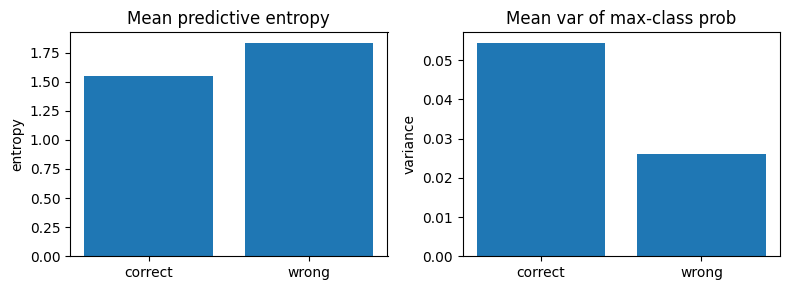

In [21]:
probs = metrics["mean_probs"]  # (N, num_classes)
targets = metrics["targets"]  # (N,)
entropy = metrics["entropy"]  # (N,)
var_max = metrics["var_maxclass"]  # (N,)

# boolean mask for correct / wrong predictions
preds = probs.argmax(dim=-1)
correct_mask = preds == targets
wrong_mask = ~correct_mask

# compute mean uncertainty for each group
mean_ent_correct = entropy[correct_mask].mean().item()
mean_ent_wrong = entropy[wrong_mask].mean().item()

mean_var_correct = var_max[correct_mask].mean().item()
mean_var_wrong = var_max[wrong_mask].mean().item()

print("Correct samples:", int(correct_mask.sum()))
print("Wrong samples   :", int(wrong_mask.sum()))
print(f"Entropy  - correct: {mean_ent_correct:.4f}, wrong: {mean_ent_wrong:.4f}")
print(f"Var(max) - correct: {mean_var_correct:.4f}, wrong: {mean_var_wrong:.4f}")

# --- bar plots ---

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# entropy
axes[0].bar(["correct", "wrong"], [mean_ent_correct, mean_ent_wrong])
axes[0].set_title("Mean predictive entropy")
axes[0].set_ylabel("entropy")

# variance of max-class prob
axes[1].bar(["correct", "wrong"], [mean_var_correct, mean_var_wrong])
axes[1].set_title("Mean var of max-class prob")
axes[1].set_ylabel("variance")

plt.tight_layout()
plt.show()

We see that both entropy and the variance of the max-class probability are higher on misclassified samples than on correctly classified ones, which indicates that the Multi-Loss Sub-Ensemble provides meaningful uncertainty estimates.


## 9. Conclusion and connection to `probly`

In this notebook we:

- reviewed the idea of full ensembles and their computational cost,
- introduced Sub-Ensembles with a shared backbone and multiple heads,
- extended this to Multi-Loss Sub-Ensembles, where each head uses a different loss,
- implemented a simple CNN-based Multi-Loss Sub-Ensemble on CIFAR-10,
- and demonstrated how to extract accuracy and basic uncertainty metrics from the ensemble.

From the perspective of `probly`, Multi-Loss Sub-Ensembles are a natural example of
an **extended ensemble structure**:

- the ensemble axis is realised by multiple heads,
- parameters are partially shared (backbone) and partially head-specific,
- each head can be associated with its own loss and possibly its own training settings.

Future work in `probly` could expose this pattern via a dedicated SubEnsemble
transformation, similar to existing ensemble utilities, so that:

- users can quickly wrap an existing backbone into a Multi-Loss Sub-Ensemble,
- and obtain uncertainty estimates without writing the full multi-head training loop
  themselves.
